# PySPPL walkthrough part 2:

In this tutorial we will start to explore more advance features of the PySPPL system. Including the build in functions, how to use compositions of functions and how to modify certain base functions. 

## Extracting variables

We will use the [coal minining model, page 105](https://cpb-us-w2.wpmucdn.com/blog.nus.edu.sg/dist/a/853/files/2012/08/ch4-x008wv.pdf), from BUGS.  As it contains a mixture of different types of variables; continuous, discrete and conditioned variables. 

In [49]:
%matplotlib inline
from pyppl import compile_model 
from pyppl.utils.core import create_network_graph, display_graph

In [56]:
model_python="""
# def obs_step(n, y, e, l, s)
#     if n+1 < s:
#         observe(exponential(e), y[n])
#         observe(exponential(1), y[n])
#     return y
e = sample(exponential(1))
l = sample(exponential(1))
T = 112
s = sample(uniform(0,10))
y = [4,5,4,1,0,4,3,4,0,6,3,3,4,0,2,6,3,3,5,4,5,3,1,4,4,1,5,5,
      3,4,2,5,2,2,3,4,2,1,3,2,1,1,1,1,1,3,0,0,1,0,1,1,0,0,3,1,
      0,3,2,2,0,1,1,1,0,1,0,1,0,0,0,2,1,0,0,0,1,1,0,2,2,3,1,1,
      2,1,1,1,1,2,4,2,0,0,0,1,4,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0]
for i in range(T-1):
    if i+1 < s:
        observe(exponential(e), y[i])
    else:
        observe(exponential(1), y[i])
[e,l,s]
"""

The coal mining disater model in clojure SPPL. 

In [57]:
model_clojure="""
(defn obs-step [n ys e l s]
  (if (< (+ n 1) s )
    (observe (exponential e) (get ys n))
    (observe (exponential l) (get ys n)))
  ys)

(let [e (sample (exponential 1))
      l (sample (exponential 1))
      T 112
      s (sample (uniform 0 10))
      ys (vector 4 5 4 1 0 4 3 4 0 6 3 3 4 0 2 6 3 3 5 4 5 3 1 4 4 1 5 5 3 4 2 5 2 2 3 4 2 1 3 2 1 1 1 1 1 3 0 0 1 0 1 1 0 0 3 1
      0 3 2 2 0 1 1 1 0 1 0 1 0 0 0 2 1 0 0 0 1 1 0 2 2 3 1 1 
      2 1 1 1 1 2 4 2 0 0 0 1 4 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0)]
  (loop 112 ys obs-step e l s)
  (vector e l s))"""
compiled_clojure =compile_model(model_clojure, language='clojure')
compiled_python = compile_model(model_python, language='python')

In [58]:
model_python_all="""
p = sample(normal(0,1))
q = sample(poisson(3))
r = sample(exponential(2))
y = [4,5,4,1,0,4,3,4,0,6]
times = 10
for i in range(times):
    if r > 2:
        observe(uniform(0,q), y[i])
    else:
        observe(normal(p, 2), y[i])
        
"""
compiled_python = compile_model(model_python_all, language='python')

### Printing the dependcy graph

In this notebook it will look fairly convoluted due to the number of parameters.

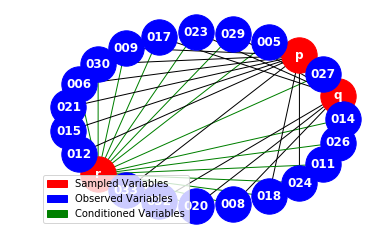

In [59]:
vertices = compiled_python.vertices
create_network_graph(vertices=vertices)
display_graph(vertices=vertices);

In [60]:
print(compiled_python.code)

# 2018-06-17 12:49:31.716196
import torch
import torch.distributions as dist


class Model():

	def __init__(self, vertices: set, arcs: set, data: set, conditionals: set):
		super().__init__()
		self.vertices = vertices
		self.arcs = arcs
		self.data = data
		self.conditionals = conditionals
	
	def __repr__(self):
		V = '\n'.join(sorted([repr(v) for v in self.vertices]))
		A = ', '.join(['({}, {})'.format(u.name, v.name) for (u, v) in self.arcs]) if len(self.arcs) > 0 else '  -'
		C = '\n'.join(sorted([repr(v) for v in self.conditionals])) if len(self.conditionals) > 0 else '  -'
		D = '\n'.join([repr(u) for u in self.data]) if len(self.data) > 0 else '  -'
		graph = 'Vertices V:\n{V}\nArcs A:\n  {A}\n\nConditions C:\n{C}\n\nData D:\n{D}\n'.format(V=V, A=A, C=C, D=D)
		graph = '#Vertices: {}, #Arcs: {}\n'.format(len(self.vertices), len(self.arcs)) + graph
		return graph
	
	def gen_cond_bit_vector(self, state):
		result = 0
		for cond in self.conditionals:
			result = cond.update_bit_ve

## Extracting the latent variables

In [61]:
model = compiled_python
_cont_latents = None if len(model.gen_cont_vars()) == 0 else model.gen_cont_vars()
_disc_latents = None if len(model.gen_disc_vars()) == 0 else model.gen_disc_vars()
_if_latents = None if len(model.gen_if_vars()) == 0 else model.gen_if_vars()


In [62]:
print('The continuous latent variables are : {0}\n The discrete latent variables are: {1}\n The conditional latent variables are: {2}'.format(_cont_latents, _disc_latents, _if_latents))

The continuous latent variables are : ['x30001']
 The discrete latent variables are: ['x30002']
 The conditional latent variables are: ['x30003']


## Extracting the original parameter names

In [66]:
# original parameter names. Parameter names are transformed in the compiler to ensure uniqueness
all_sampled_vars = compiled_python.get_vars()
print(all_sampled_vars)
_names = dict(
    [(vertex.name, vertex.original_name) for vertex in vertices if vertex.name in _all_vars])# distribution arguments and names


for key in _names:
    print('Unique name in compiler: {0} User defined name:  {1}'.format(key, _names[key]))

['y30014', 'y30027', 'x30001', 'y30005', 'x30002', 'y30029', 'y30023', 'y30017', 'y30009', 'y30030', 'y30006', 'y30021', 'y30015', 'y30012', 'x30003', 'y30033', 'y30032', 'y30020', 'y30008', 'y30018', 'y30024', 'y30011', 'y30026']
['x30001', 'x30002', 'x30003']
Unique name in compiler: x30001 User defined name:  p
Unique name in compiler: x30002 User defined name:  q
Unique name in compiler: x30003 User defined name:  r


## Extracting the distribution names and parameters

The flexibilty of the system allows the user to manipulate and reconstruct distribution objects, dependent upon the library they want to use.  

In [ ]:
_dist_params = {}
for vertex in vertices:
    if vertex.is_sampled:
        _dist_params[vertex.name] = {vertex.distribution_name: vertex.distribution_arguments}


# distribution type of each latent variable, used for the bijections and embeddings
_cont_dists = dict([(vertex.name, vertex.distribution_name) for vertex in _vertices if
                         (vertex.is_continuous and vertex.name in _all_vars)])
_disc_dists = dict([(vertex.name, vertex.distribution_name) for vertex in _vertices if
                         (vertex.is_discrete and vertex.name in _all_vars)])

In [48]:
print(_dist_params)
print(_cont_dists)
print(_disc_dists)

{'x30003': {'Exponential': {'rate': '2'}}, 'x30001': {'Normal': {'loc': '0', 'scale': '1'}}, 'x30002': {'Poisson': {'lam': '3'}}}
{'x30001': 'Exponential', 'x30002': 'Exponential', 'x30003': 'Uniform'}
{}


In [ ]:
#print('Debebug statement in MCMC.generate_latents() \n Printing if vars : {} '.format(_if_latents))
# each predicate has a cond boolean parameter, which represents the evaluated value of the predicate, whenever
# the log_pdf is calculated.
_cond_bools = None if len(model.gen_if_vars()) == 0 else model.gen_cond_vars()
# all vertices of the graph are objects.
_vertices = model.get_vertices()
# A list of all observables
observables = dict([(vertex.name, vertex.observation) for vertex in _vertices if vertex.is_observed])
# a list of all latent vars
_all_vars = [vertex.name for vertex in _vertices if vertex.is_sampled]
_number_of_latents = len(_all_vars)
# distribution type of each latent variable, used for the bijections and embeddings
# TODO fix this function _disc_support = dict()
# key: values of parameter name and string of distribution object.
_dist_obj = {}
if _disc_latents:
    for param in _disc_latents:
        for dist in _dist_params[param]:
            i = 0
            _dist_obj[param] = ''
            for key in [_dist_params[param][dist]]:
                _dist_obj[param] = _dist_obj[param] + key + '=' + _dist_params[param][dist][key]
                i += 1
                if len(_dist_params[param][dist].keys()) > 1 and i == 1:
                    _dist_obj[param] = _dist_obj[param] + ','
                if len(_dist_params[param][dist].keys()) > 2 and i == 2:
                    _dist_obj[param] = _dist_obj[param] + ','
            _dist_obj[param] = dist + '( {0} )'.format(_dist_obj[param])
    # discrete support sizes using the __dist_obj get the support of each
    # distribution by reconstructing it. Might be able to include this in the outer for loop.
    _discrete_support = {}

_ancestors = {}
for v in _vertices:
    if v.is_sampled:
        for a in v.ancestors:
            _ancestors[a.name] = v.name

